# Diabetes Patient Readmission Problem
Author: Juan Echeverri<br>
Email:  jecheverrigutierrez@gmail.com<br>
Resume: http://jecheverrigutierrez.s3-website-us-east-1.amazonaws.com/
## Classification with Diabetes readmission dataset
source : https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#<br>

The data are submitted on behalf of the Center for Clinical and Translational Research, Virginia Commonwealth University, a recipient of NIH CTSA grant UL1 TR00058 and a recipient of the CERNER data. John Clore (jclore '@' vcu.edu), Krzysztof J. Cios (kcios '@' vcu.edu), Jon DeShazo (jpdeshazo '@' vcu.edu), and Beata Strack (strackb '@' vcu.edu). This data is a de-identified abstract of the Health Facts database (Cerner Corporation, Kansas City, MO).


Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1) It is an inpatient encounter (a hospital admission).
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3) The length of stay was at least 1 day and at most 14 days.
(4) Laboratory tests were performed during the encounter.
(5) Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

# Problem Scope

I have decided to solve the problem considering it as a binary classification problem, assuming that "No" = 0, otherwise 1. This was decided base ond the next description:

1. No readmission <br>
2. A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate); <br>
3. A readmission in more than 30 days (this one is not so good as well the last one, however, the reason could be the state of the patient.<br>

## Libraries and some basic settings

In [165]:
# Permanent reloading scripts and sources
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Libaries required to perform the training, the hyperparameters tunning and the measurement of the model performance.

In [269]:
# Import required libraries
import os
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy import sparse
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import AUC
from keras.optimizers import Adam
import eli5
from eli5.sklearn import PermutationImportance

In [167]:
# Root Path of project (It may be not required depending on the IDE configuration)
# os.chdir(r'/home/ec2-user/SageMaker/diabetes/')
os.chdir(r'\Users\war-machine\Desktop\diabetes/')

In [168]:
# Import source files and utils
from src.data.get_raw_data import *
from src.features.build_features import *
from src.data.variables_set import *

## Download DataSet

these lines must be run only once in case there is no data inside the folder "/data/raw"

In [169]:
# databasepath = 'data/raw/'
# filename = 'dataset_uci.zip'
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip'
# output = DownloadDatabase(databasepath,filename,url)

In [170]:
path_dataset = 'data/raw/diabetic_data.csv'
path_idmappings = r'data/raw/IDs_mapping.csv'

In [171]:
df_raw = pd.read_csv(path_dataset)
df_mapping = pd.read_csv(path_idmappings)

## Dataset Description <br>
Below the dataset variables with the type, description and the missing percentage.<br> The 3 variables with more than 50% of missing values will be dropped.

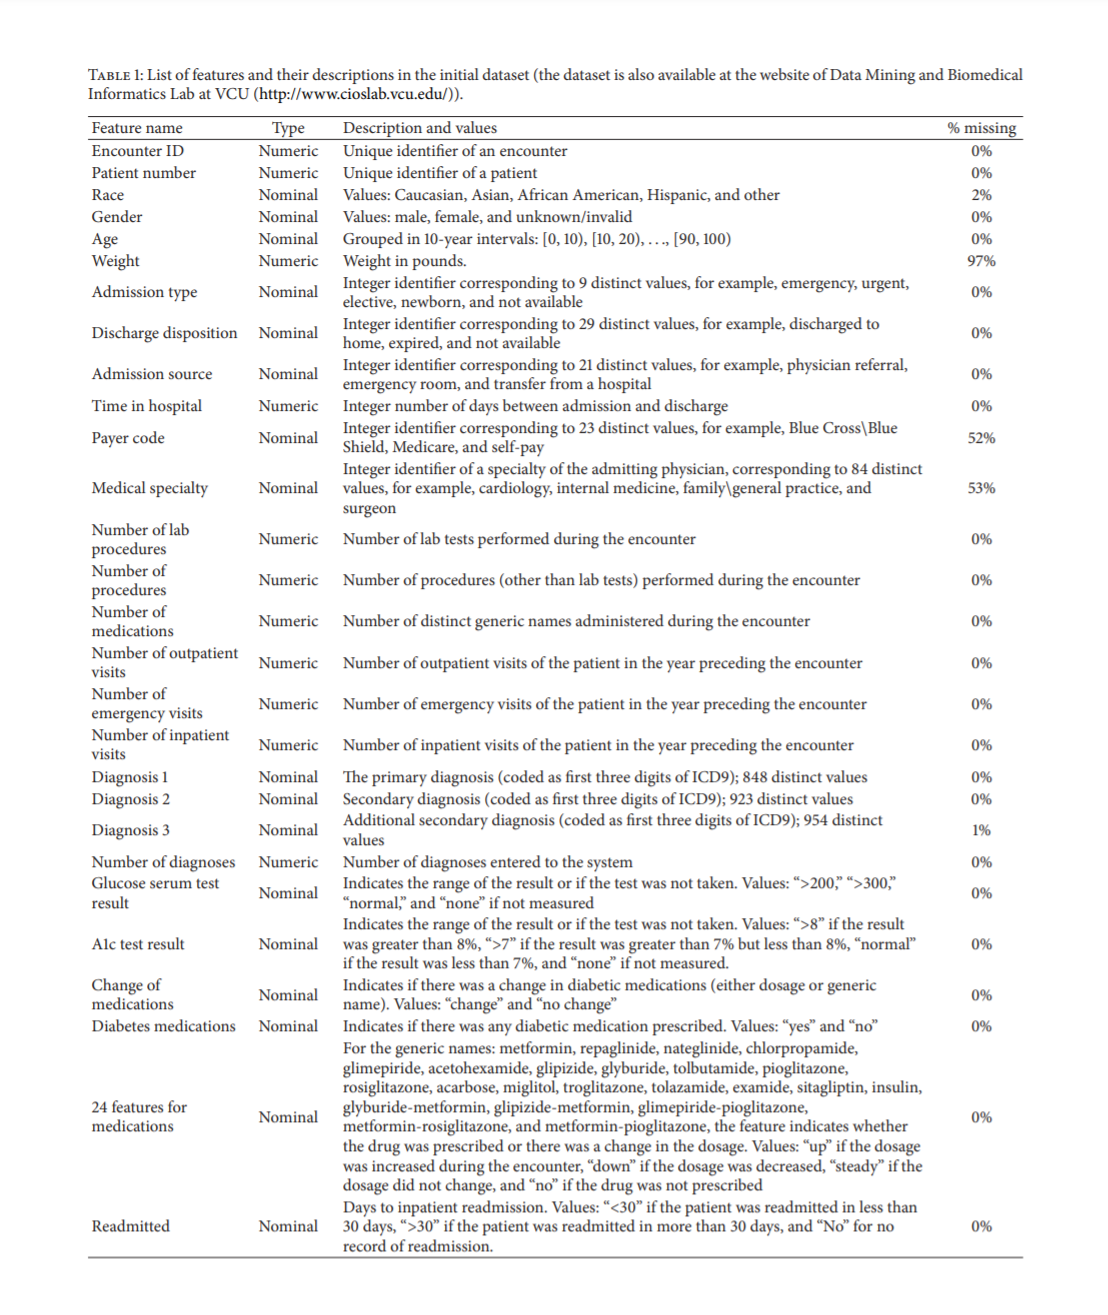

In [172]:
Image(filename="references/description.png", width=500)

From the above image it is easily inferred that the variables **(incounter_id, patient_nbr)** are not useful at all.

## Feature Engineering

In [173]:
df_raw.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


From the above image, '?' characters are used in use case of missing values. Let's replace them with "nan".

In [174]:
df = df_raw.replace('?',np.nan)

Let's calculate missing values percentage, **just to make sure the variables to be dropped are the same that I mentioned earlier in the dataset description.**

In [175]:
df_missing = df.isna()
df_num_missing = df_missing.sum()
perc_missing_values = df_num_missing / len(df) * 100
# perc_missing_values = df_num_missing
perc_missing_values.sort_values(ascending=False,inplace=True)
perc_missing_values[:10]

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
num_procedures        0.000000
max_glu_serum         0.000000
number_diagnoses      0.000000
dtype: float64

Even though the actual missing values for medical_specialty and player_code are different from dataset description, those do are the variables to be dropped, because of the large number of missing values. Since only little data is missing, droping the rows is valid instead of statistical imputation.


In [176]:
df.dropna(subset=['race', 'diag_3','diag_2','diag_1'], inplace=True)


Let's check duplicated rows

In [177]:
sum(df.duplicated(keep='last'))

0

Let's analyse whether the dataset is balaneced or unbalanced.

According to the description of the problem, below is the output interpretation.

1. No readmission;
2. A readmission in less than 30 days (this situation is not good, because maybe
your treatment was not appropriate);
3. A readmission in more than 30 days (this one is not so good as well the last
one, however, the reason could be the state of the patient.

In [178]:
df['readmitted'].value_counts()

NO     52338
>30    34649
<30    11066
Name: readmitted, dtype: int64

From the above results, the next approaches could be possible:

1) Merge the values ">30" and "<30" considering that both are "negative" situations. This approach would result in a more balanced dataset, which is great for classifiers.

2) The dataset could be balaced with techniques like SMOTE or ANN

So far we've got these variables to drop.

In [179]:
features_to_drop = [
'encounter_id', # inutil para el clasificador
'patient_nbr',# inutil para el clasificador
'weight', # 96,8% de missing values
'medical_specialty', # 49.0 % de missing values
'payer_code', # 39.0 % de missing values
]

#### Let's review sistematically each of the remaining features.

In [180]:
print([i for i in list(df) if i not in features_to_drop])

['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [181]:
# Nominal feature: one hot encoder will be used to encode.
df['race'].value_counts()

Caucasian          75079
AfricanAmerican    18881
Hispanic            1984
Other               1484
Asian                625
Name: race, dtype: int64

In [182]:
# Nominal feature: one hot encoder will be used to encode.
# Unknown/Invalid register is deleted
df['gender'].value_counts()

Female             52833
Male               45219
Unknown/Invalid        1
Name: gender, dtype: int64

In [183]:
df = df[df['gender'] != 'Unknown/Invalid']

Feature engineering for feature: "age"

In [184]:
df['age'].value_counts()

[70-80)     25305
[60-70)     21809
[80-90)     16702
[50-60)     16697
[40-50)      9265
[30-40)      3548
[90-100)     2717
[20-30)      1478
[10-20)       466
[0-10)         65
Name: age, dtype: int64

##### According to this research ""Mingle, D. Predicting diabetic readmission rates: Moving beyond hba1c. Current Trends in Biomedical Engineering & Biosciences 7 (01 2017).", the next grouping for this feature is performed.

In [185]:
# It is created a range variables: under 30, between 30 and 70 and greater than 70
age_mapping = {'[0-10)':'menor30','[10-20)':'menor30','[20-30)':'menor30','[90-100)':'mayor70','[30-40)':'menor70',
               '[40-50)':'menor70','[50-60)':'menor70','[80-90)':'mayor70','[60-70)':'mayor70','[70-80)':'mayor70'}
df['age_grouped'] = df['age'].apply(lambda x : age_mapping[x])

In [186]:
df['age_grouped'].value_counts()


mayor70    66533
menor70    29510
menor30     2009
Name: age_grouped, dtype: int64

In [187]:
# Feature type: ordinal. First let's code it with the middle number between the limits.
age_mapping = {'[0-10)':5,'[10-20)':15,'[20-30)':25,'[90-100)':95,'[30-40)':35,
               '[40-50)':45,'[50-60)':55,'[80-90)':85,'[60-70)':65,'[70-80)':75}
df['age'] = df['age'].apply(lambda x : age_mapping[x])

In [188]:
df['age'].value_counts()

75    25305
65    21809
85    16702
55    16697
45     9265
35     3548
95     2717
25     1478
15      466
5        65
Name: age, dtype: int64

#### Feature Engineering : admission_type_id<br>

Since emergency, urgent and trauma are conceptually similar, let's group them together.
Similarly, let's group "null" and "not available", because they mean the same. Remaining variables are not group because there is no an interpretation logic to do it.

The meaning of the numeric values of this variable were taken from: "https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#"

In [189]:
def prep_adm_discharge_map(df,descr,desiredname,mappin_dictio):    
	df[desiredname] = df[descr].apply(lambda x : mappin_dictio[x])
	return df

In [190]:
df['admission_type_id'].value_counts()

1    52178
3    18193
2    17543
6     5135
5     4661
8      312
7       20
4       10
Name: admission_type_id, dtype: int64

 In order to test different datasets, let's create one without grouping the values and other one grouping them

In [191]:
dictio_admision_type_conglo = {1:'grave',2:'grave',3:'eleccionpropia',4:'reciennacido',
                               5:'nodisponible',6:'nodisponible',7:'grave',8:'nodisponible'
                              }

dictio_admision_type_no_conglo = {1:'emergencia',2:'urgente',3:'eleccionpropia',4:'reciennacido',
                                  5:'nodisponible',6:'nodisponible',7:'trauma',8:'nodisponible'
                                 }

df = prep_adm_discharge_map(df,'admission_type_id','admission_type_id_v1',dictio_admision_type_conglo)

df = prep_adm_discharge_map(df,'admission_type_id','admission_type_id_v2',dictio_admision_type_no_conglo)

#### Feature Engineering for feature: "discharge_disposition_id"

From the original dataset main URL: "https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#" can be taken the numeric values and the meaning. By performing a logical grouping of this variables to reduce the number of features, below are the grouping performed.

* 1,6,8,9,13: still hospitalized (home or hospital)
* 2, 3, 4, 5, 14, 22, 23, 24: (transferred to other hospital type: potentially other illness)
* 10, 12, 15, 16, 17: (transferred to the same type hospital, potentially same illness)
* 11, 19, 20, 21: (dead or about the die)
* 18, 25, 25: (not available data)

Just for test purposes, a column with the original mapping and other with the merged one are created.

In [192]:
id_disp=['hospitalizado_casa_uhospital','transferido_a_otro_hosp','transferido_a_mismo_hosp','muerto_hospitalizado',
     	'nodisponible','dejo_AMA','transferido_facilidad_federal','transferido_hospita_siquiatrico']

discharge_disposition_id_conglo = {
1:id_disp[0],6:id_disp[0],8:id_disp[0],9:id_disp[0],13:id_disp[0],
2:id_disp[1],3:id_disp[1],4:id_disp[1],5:id_disp[1],14:id_disp[1],22:id_disp[1],23:id_disp[1],24:id_disp[1],
10:id_disp[2],12:id_disp[2],15:id_disp[2],16:id_disp[2],17:id_disp[2],
11:id_disp[3],19:id_disp[3],20:id_disp[3],21:id_disp[3],18:id_disp[4],25:id_disp[4],26:id_disp[4],
7:id_disp[5], 27:id_disp[6],28:id_disp[7]}

df = prep_adm_discharge_map(df,'discharge_disposition_id','discharge_disposition_id_v1',discharge_disposition_id_conglo)
df['discharge_disposition_id_v1'].value_counts()


hospitalizado_casa_uhospital       70758
transferido_a_otro_hosp            20282
nodisponible                        4565
muerto_hospitalizado                1616
dejo_AMA                             592
transferido_hospita_siquiatrico      137
transferido_a_mismo_hosp              97
transferido_facilidad_federal          5
Name: discharge_disposition_id_v1, dtype: int64

In [193]:
discharge_disposition_id_no_conglo ={1:'alta_a_casa',2:'transfer_hosp_paso',3:'transfer_snf',4:'transfer_icf',
5:'transfer_inst_paso',6:'transfer_casa_ayuda_hosp',7:'dejo_AMA',
8:'transfer_casa_ayuda_clinica',9:'admitido_hospital',10:'transfer_cuidado_postnatal',
11:'muerto',12:'seespera_que_regrese',13:'hospitali_terminal_encasa',
14:'hospitaliza_terminal_hospital',15:'transfer_dentro',16:'transfer_fuera_servicioshostp',
17:'transfer_dentro_servicioshostp',18:'nodisponible',19:'muerto_terminal_casa',
20:'muerto_terminal_hosp',21:'muerto_terminal_otrolugar',22:'transfer_unidad_rehabili',
23:'transfer_hospital_largoperiodo',24:'transfer_facilidad_con_enfermeras',25:'nodisponible',
26:'nodisponible',27:'transfer_hosp_federal',28:'transfer_hosp_siquiatrico',
29:'trasnfer_a_hosp_critico',30:'transfer_institucion_salud_nodefinida'}

df = prep_adm_discharge_map(df,'discharge_disposition_id','discharge_disposition_id_v2',discharge_disposition_id_no_conglo)
df['discharge_disposition_id_v2'].value_counts()


alta_a_casa                          57609
transfer_snf                         13564
transfer_casa_ayuda_hosp             12626
nodisponible                          4565
transfer_hosp_paso                    2049
transfer_unidad_rehabili              1970
muerto                                1606
transfer_inst_paso                    1127
transfer_icf                           756
dejo_AMA                               592
transfer_hospital_largoperiodo         400
hospitali_terminal_encasa              396
hospitaliza_terminal_hospital          368
transfer_hosp_siquiatrico              137
transfer_casa_ayuda_clinica            106
transfer_dentro                         63
transfer_facilidad_con_enfermeras       48
admitido_hospital                       21
transfer_dentro_servicioshostp          14
transfer_fuera_servicioshostp           11
muerto_terminal_casa                     8
transfer_cuidado_postnatal               6
transfer_hosp_federal                    5
seespera_qu

#### admission_source_id: With the same above explanation, the original and the merged featured are added to datasets. The tags are used to give the model the ability to be self explained after performing one hot encoding.


In [194]:
id_disp_2=['referido_de_clinica','transferido_desde_centro_especializado','nodisponible','bebe_normal','viene_sala_emergencia','viene_por_fuerza_de_ley']
admission_source_id_mapping_1 = {
                                1:id_disp_2[0],2:id_disp_2[0],3:id_disp_2[0],
                                4:id_disp_2[1],5:id_disp_2[1],6:id_disp_2[1],10:id_disp_2[1],22:id_disp_2[1],25:id_disp_2[1],
                                9:id_disp_2[2],15:id_disp_2[2],17:id_disp_2[2],20:id_disp_2[2],21:id_disp_2[2],
                                11:id_disp_2[3],13:id_disp_2[3],14:id_disp_2[3],
                                7:id_disp_2[4],8:id_disp_2[5]
                                }

df = prep_adm_discharge_map(df,'admission_source_id','admission_source_id_v1',admission_source_id_mapping_1)
df['admission_source_id_v1'].value_counts()


viene_sala_emergencia                     55951
referido_de_clinica                       29565
nodisponible                               6811
transferido_desde_centro_especializado     5705
viene_por_fuerza_de_ley                      15
bebe_normal                                   5
Name: admission_source_id_v1, dtype: int64

In [195]:
admission_source_id_mapping_1_noconglo={
                                1:'refer_siquiatrico',2:'refer_clinica',3:'refer_HMO',4:'transfer_de_hospital',
                                5:'transfer_de_SNF',6:'transfer_de_otro_centro_hosp',7:'sala_emergencia',
                                8:'obligado_por_ley',9:'nodisponible',10:'transfer_de_hospital_critico',
                                11:'nacimiento_normal',12:'nacimiento_prematur',13:'bebe_enfermo',
                                14:'extramural_nacimiento',15:'nodisponible',17:'nodisponible',
                                18:'transfer_de_agencia_salud',19:'readmitido_a_agenciasalud',20:'nodisponible',
                                21:'nodisponible',22:'transfer_de_hosp_mismo_depto',23:'nacido_dentro_hospital',
                                24:'nacido_fuera_hospital',25:'transfer_de_centro_cirugia',26:'transfer_de_hospital'}

df = prep_adm_discharge_map(df,'admission_source_id','admission_source_id_v2',admission_source_id_mapping_1_noconglo)
df['admission_source_id_v2'].value_counts()


sala_emergencia                 55951
refer_siquiatrico               28355
nodisponible                     6811
transfer_de_hospital             2945
transfer_de_otro_centro_hosp     1893
refer_clinica                    1031
transfer_de_SNF                   846
refer_HMO                         179
obligado_por_ley                   15
transfer_de_hosp_mismo_depto       12
transfer_de_hospital_critico        7
transfer_de_centro_cirugia          2
extramural_nacimiento               2
nacimiento_normal                   2
bebe_enfermo                        1
Name: admission_source_id_v2, dtype: int64

Feature Engineering: "max_glu_serum"

In [196]:
df['max_glu_serum'].value_counts()

None    92844
Norm     2532
>200     1449
>300     1227
Name: max_glu_serum, dtype: int64

In [197]:
max_glu_serum_mapping = {'>200':200,'>300':300,'Norm':100,'None':'0'}
df['max_glu_serum'] = df['max_glu_serum'].apply(lambda x : max_glu_serum_mapping[x])

In [198]:
df['max_glu_serum'].value_counts()

0      92844
100     2532
200     1449
300     1227
Name: max_glu_serum, dtype: int64

Feature engineering: "A1Cresult"

In [199]:
df['A1Cresult'].value_counts()

None    81859
>8       7631
Norm     4854
>7       3708
Name: A1Cresult, dtype: int64

In [200]:
A1Cresult_mapping = {'>7':7,'>8':8,'Norm':5,'None':0}
df['A1Cresult_v1'] = df['A1Cresult'].apply(lambda x : A1Cresult_mapping[x])

In [201]:
df['A1Cresult_v1'].value_counts()

0    81859
8     7631
5     4854
7     3708
Name: A1Cresult_v1, dtype: int64

#### Drugs features

In [202]:
drug_list = ['insulin','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
           'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
           'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
           'metformin-rosiglitazone', 'metformin-pioglitazone',]


According to the variance of this variable, only insulin, metmorfin and glipzide are useful.

In [203]:
(df[drug_list].apply(pd.Series.value_counts).T/len(df)*100).sort_values(by=['No']).head(10)

,Down,No,Steady,Up
insulin,12.078285,46.854730,29.951454,11.115531
metformin,0.561947,80.372659,18.028189,1.037205
glipizide,0.551748,87.472974,11.208338,0.766940
glyburide,0.548688,89.535145,9.109452,0.806715
pioglitazone,0.117285,92.762004,6.889202,0.231510
rosiglitazone,0.085669,93.711500,6.025374,0.177457
glimepiride,0.187656,94.913923,4.577163,0.321258
repaglinide,0.045894,98.446743,1.398238,0.109126
nateglinide,0.011219,99.295272,0.670053,0.023457
glyburide-metformin,0.003060,99.317709,0.673112,0.006119


Feature engineering: insulin, metformin, glipizide: These variables are encoded to numbers, assuming they are ordinal.

In [204]:
drugs_mapping = {'Up':15, 'Steady':10,'Down':5,'No':0}
drugs_keep = ['insulin', 'metformin', 'glipizide']
for i in drugs_keep:
    df[i] = df[i].apply(lambda x : drugs_mapping[x])

In [205]:
(df[drugs_keep].apply(pd.Series.value_counts).T/len(df)*100).sort_values(by=[0]).head(10)

,0,5,10,15
insulin,46.854730,12.078285,29.951454,11.115531
metformin,80.372659,0.561947,18.028189,1.037205
glipizide,87.472974,0.551748,11.208338,0.766940


In [206]:
df[drugs_keep].describe()

,insulin,metformin,glipizide
count,98052.000000,98052.000000,98052.000000
mean,5.266389,1.986497,1.263462
std,5.499675,4.068954,3.387576
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,10.000000,0.000000,0.000000
max,15.000000,15.000000,15.000000


In [207]:
# drug_list = [i for i in drug_list if i not in drugs_keep]

Feature engineering change

In [208]:
# Categorical feature, one hot encoding will be performed
df['change'].value_counts()

No    52774
Ch    45278
Name: change, dtype: int64

Feature Engineering: diabetesMed

In [209]:
# Categorical feature, one hot encoding will be performed
df['diabetesMed'].value_counts()

Yes    75350
No     22702
Name: diabetesMed, dtype: int64

### Feature enginnering de diag_i <br>
Base on this research: # source https://www.hindawi.com/journals/bmri/2014/781670/tab2/, the number from this variable are mapped to categories, in relation with a specific illness.

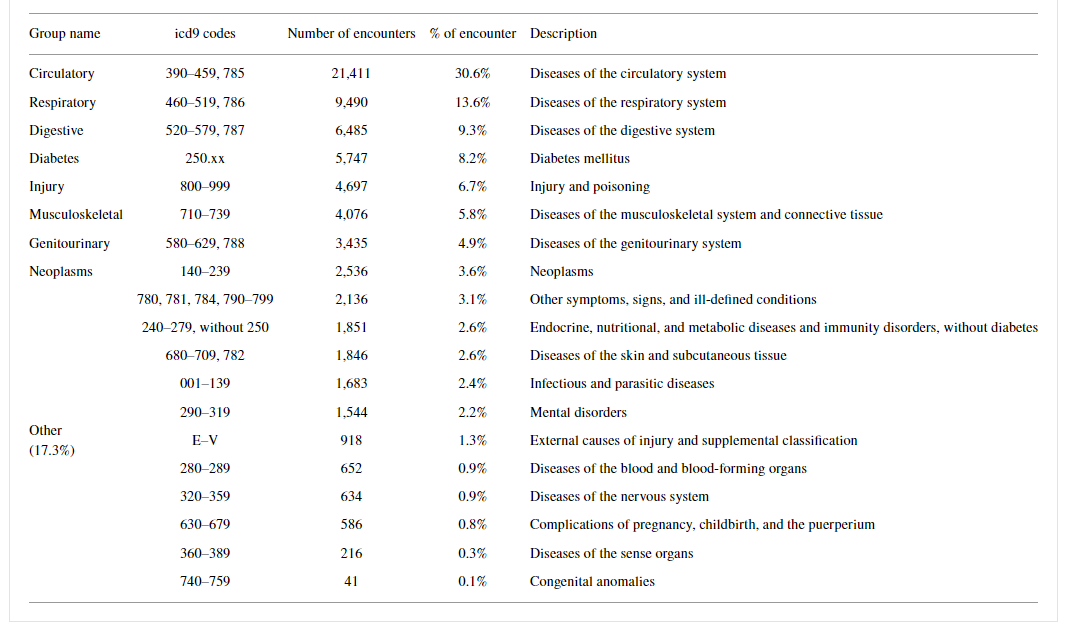

In [210]:

Image(filename="references/icd9groups.png", width=800)

In [211]:
def prep_diags(df,descr,prefix):
    new_name = descr + '_' + prefix
    df[new_name] = df[descr].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                                else  ('digestive'   if (int(float(x)) >= 520 and int(float(x)) < 580) or (int(float(x))) == 787
                                                else ('neoplasms'	if (int(float(x)) >= 140 and int(float(x)) < 240)
                                                else ('diabetes'	if (int(float(x)) == 250)
                                                else ('musculoskeletal' if (int(float(x)) >= 710 and int(float(x)) < 740)
                                                else ('injury'  	if (int(float(x)) >= 800 and int(float(x)) < 1000)
                                                else ('circulatory' if (int(float(x)) >= 390 and int(float(x)) < 460) or (int(float(x))) == 785
                                                else ('respiratory' if (int(float(x)) >= 460 and int(float(x)) < 520) or (int(float(x))) == 786                                                                   	 
                                                else ('genitourinary'   if (int(float(x)) >= 580 and int(float(x)) < 630) or (int(float(x))) == 788
                                                else 'other')))))))))
    return df

df = prep_diags(df,'diag_1','v1')
df = prep_diags(df,'diag_2','v1')
df = prep_diags(df,'diag_3','v1')

## Creating new features: <br>
Inspired on [Sarthak,2020], two new features are created: Count_change meds is the total ammount of changes in medications, a change is considered as: "down to up" or "up to down". Service utilization is the sum of the number of inpatient visits, the number of outpatient visits, and the number of emergency visits. **This variable is the second most important one of the model, according to the importance fearures analysis made further.**


##### count_change_meds

In [212]:
drug_list = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride','acetohexamide',
         	'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone','rosiglitazone', 'acarbose',
         	'miglitol', 'troglitazone', 'tolazamide', 'examide','citoglipton', 'glyburide-metformin',
         	'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone',
         	'metformin-pioglitazone','insulin']

new_variable = 'count_change_meds'
df[drug_list] = df[drug_list].applymap(lambda x : 1 if str(x) == 'Up' or str(x) == 'Down' else 0)
df[new_variable] = df[drug_list].apply(lambda x : sum([*x]), axis=1)
df[new_variable].value_counts()

0    95455
1     2545
2       51
3        1
Name: count_change_meds, dtype: int64

#### service_utilization

In [213]:
new_variable_2 = 'service_utilization' #NUMERICA
visits_list = ['number_outpatient','number_emergency','number_inpatient']
df[new_variable_2] = df[visits_list].apply(lambda x : sum([*x]), axis=1)
df[new_variable_2].value_counts()

0     53125
1     19406
2      9859
3      5795
4      3506
5      1997
6      1287
7       857
8       544
9       426
10      270
11      245
12      136
13       98
15       95
14       86
16       67
17       62
18       32
19       30
20       23
22       15
21       14
24        9
27        9
25        7
26        6
29        5
36        5
35        5
30        4
23        4
38        2
37        2
42        2
33        2
32        2
31        2
28        2
68        2
41        1
48        1
49        1
40        1
34        1
80        1
61        1
Name: service_utilization, dtype: int64

#### Dropping rows corresponding to dead or about to die people ("expired")

Even though this variable is strongly predictive, it makes no sense to include it inside the model,since <br>
in real situations, no "dead" patients can be readdmited. This is performed to avoid the so called common issue<br>
data-leakage: "https://machinelearningmastery.com/data-leakage-machine-learning/"


In [214]:
df['discharge_disposition_id_v1']=df['discharge_disposition_id_v1'].replace('muerto_hospitalizado',np.nan)
df['discharge_disposition_id_v1'].value_counts()
df.dropna(subset=['discharge_disposition_id_v1'], inplace=True)

#### Creating variables of binary output

In [215]:
df['readmitted'].value_counts()

NO     50721
>30    34649
<30    11066
Name: readmitted, dtype: int64

In [216]:
binary_readmitted_mapping = {'NO':0,'>30':1,'<30':1}
df['binary_readmitted_v1'] = df['readmitted'].apply(lambda x : binary_readmitted_mapping[x])

In [217]:
df['binary_readmitted_v1'].value_counts()

0    50721
1    45715
Name: binary_readmitted_v1, dtype: int64

In [218]:
binary_readmitted_mapping = {'NO':0,'>30':0,'<30':1}
df['binary_readmitted_v2'] = df['readmitted'].apply(lambda x : binary_readmitted_mapping[x])

In [219]:
df['binary_readmitted_v2'].value_counts()

0    85370
1    11066
Name: binary_readmitted_v2, dtype: int64

Other dataframe is created with only the first row for each patient, both are used to choose to test different <br>
approaches.

In [220]:
df_70k = df[df.duplicated(keep='first',subset=['patient_nbr'])==False]
len(df_70k)

67573

## Preprocessing

As a result of the featuring engineering performed, it is created the file "\src\data\variables_set.py", in this file are created the lists with different set variables (test purposes)

* set_variables_v1
* set_variables_v2
* set_variables_v3

### Next steps:
* One-hot encoding for nominal features.
* standarization or scaling the numeric and ordinal variables.
* Creating training and test datasets.

I decide to use one-hot encoder of scikit-learn and not the pandas one, since in my experience, this one makes easier the model deployment: because with the sklearn it is only required to serialize the encouder. This remove some possible errors and load to the backend layer.


#### imblearn shoould be installed to perform SMOTE in order to make oversampling

#### This function is created in order to make easier the different test by combining: datasets, different features engineerings and different variables: This function automates the process of creating the training and test datasets and performing the encoding and scaling base on the inputs given to the function.

In [224]:
def createartifacts(dfi,keydata,vsets):
    artifacti = {}
    for keyvariablesets,i in vsets.items():
        
        features_to_drop = i['drop']
        ordinal_features_to_keep = i['ordinal']
        categorical_features_to_keep = i['categorical']
        numerical_features_to_keep = i['numerical']

        numerical = numerical_features_to_keep + ordinal_features_to_keep
        df_num = dfi[numerical]

        # escalador
        scaler = StandardScaler()
        scaler.fit(dfi[numerical])
        x_stand = scaler.transform(dfi[numerical])

        # x estandarizada
        df_x_stand = pd.DataFrame(x_stand, columns = numerical)

        # onehotencoder
        enc = OneHotEncoder(drop='if_binary')
        enc.fit(dfi[categorical_features_to_keep].astype(str))
        x_onehot = enc.transform(dfi[categorical_features_to_keep].astype(str))

        # x codificada
        df_x_onehot = pd.DataFrame.sparse.from_spmatrix(x_onehot, columns=enc.get_feature_names())


        X = pd.concat([df_x_stand, df_x_onehot], axis = 1)
        y_v1 = dfi['binary_readmitted_v1']
        y_v2 = dfi['binary_readmitted_v2']
        

        X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(sparse.csr_matrix(X.values), y_v1.values.ravel(),
                                                            test_size=0.20, random_state=42, stratify=y_v1)

        X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(sparse.csr_matrix(X.values), y_v2.values.ravel(),
                                                            test_size=0.20, random_state=42, stratify=y_v2)
        
        # oversample en el caso de y_v2
        oversample = SMOTE()
        X_train_v2_over, y_train_v2_over = oversample.fit_resample(X_train_v2, y_train_v2)
        
        artifacti[keyvariablesets] = {'set_variables':keyvariablesets, 'dataset':keydata,
                                       'scaler':scaler,'onehot':enc, 
                                       'train_v1': [X_train_v1, y_train_v1], 'test_v1':[X_test_v1,y_test_v1],
                                       'train_v2': [X_train_v2, y_train_v2], 'test_v2':[X_test_v2,y_test_v2],
                                       'train_v2_over': [X_train_v2_over, y_train_v2_over]
                                      }
    return artifacti

#### Two dictionaries are created: one containing the variable sets and other containing the dataframes associated with.

In [226]:
vsets = {'set_1':set_variables_v1, 'set_2':set_variables_v2, 'set_3':set_variables_v3}
datasets_vi = {'df':df, 'df_70k':df_70k}
lista_datos = {}
for keydata, dfi in datasets_vi.items():
    lista_datos[keydata] = createartifacts(dfi,keydata,vsets) 

## Training models

#### testsmodels function is written to automate the process of training with different algorithms and datasets and calculating the performance with ROC

In [245]:
def testmodels(model, namemodel, label_train,label_test,datasets_vi,vsets):
    for datos in datasets_vi:
        for var_set in vsets:

            label_data = datos
            label_variable_set = var_set
            label_train = 'train_v1'
            label_test = 'test_v1'

            print("Experimento-{namemodel}-{datos}-{var_set}-{label_train}-{label_test}".format(
                            datos=datos,
                            var_set=var_set,
                            label_train=label_train,
                            label_test=label_test,
                            namemodel = namemodel
            ))

            X_train = lista_datos[label_data][label_variable_set][label_train][0]
            y_train = lista_datos[label_data][label_variable_set][label_train][1]
            X_test  = lista_datos[label_data][label_variable_set][label_test][0]
            y_test = lista_datos[label_data][label_variable_set][label_test][1]

            model.fit(X_train, y_train)

            y_lr_proba_predicted = model.predict_proba(X_test)[:, 1]
            y_lr_predicted = model.predict(X_test)
            print("ROC - {roc}".format(roc=roc_auc_score(y_test, y_lr_proba_predicted)))
            print("ACC - {acc}".format(acc=accuracy_score(y_test, y_lr_predicted)))
            

    return model

### Stochastic Gradient Descent  - SGDClassifier

In [246]:
lr_model = SGDClassifier(alpha = 0.005, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                         random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                         early_stopping = True, n_iter_no_change = 3,  verbose=0
                          )

In [247]:
testmodels(lr_model, 'SGDClassifier', 'train_v1','test_v1',datasets_vi,vsets)

Experimento-SGDClassifier-df-set_1-train_v1-test_v1
ROC - 0.6575112687102311
ACC - 0.6167046868519287
Experimento-SGDClassifier-df-set_2-train_v1-test_v1
ROC - 0.6577876828855919
ACC - 0.6173786810452094
Experimento-SGDClassifier-df-set_3-train_v1-test_v1
ROC - 0.658325266895896
ACC - 0.6164973040232269
Experimento-SGDClassifier-df_70k-set_1-train_v1-test_v1
ROC - 0.6279867447107733
ACC - 0.5938586755456899
Experimento-SGDClassifier-df_70k-set_2-train_v1-test_v1
ROC - 0.6279490593637862
ACC - 0.5937846836847946
Experimento-SGDClassifier-df_70k-set_3-train_v1-test_v1
ROC - 0.6299471744630698
ACC - 0.5969663337032927


SGDClassifier(alpha=0.005, class_weight='balanced', early_stopping=True,
              eta0=0.001, learning_rate='adaptive', loss='log',
              n_iter_no_change=3, penalty='elasticnet', random_state=24)

### RandomForestClassifier binay problem

In [236]:
rf = RandomForestClassifier(max_features = 'sqrt', max_samples = 0.8, 
                            class_weight = "balanced", max_depth = 10,
                            n_estimators = 100
                           )

In [237]:
testmodels(rf, 'Random forest', 'train_v1','test_v1',datasets_vi,vsets)

Experimento-Random forest-df-set_1-train_v1-test_v1
ROC - 0.6703990755935468
ACC - 0.6199709664039817
Experimento-Random forest-df-set_2-train_v1-test_v1
ROC - 0.6709220459521991
ACC - 0.6225114060555786
Experimento-Random forest-df-set_3-train_v1-test_v1
ROC - 0.6735565245642223
ACC - 0.6257258399004563
Experimento-Random forest-df_70k-set_1-train_v1-test_v1
ROC - 0.6423689751060461
ACC - 0.6059193488716241
Experimento-Random forest-df_70k-set_2-train_v1-test_v1
ROC - 0.6421584257604545
ACC - 0.6039215686274509
Experimento-Random forest-df_70k-set_3-train_v1-test_v1
ROC - 0.6462210690315029
ACC - 0.607103218645949


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', max_samples=0.8)

### Xgboost

In [238]:
xgb_model = GradientBoostingClassifier(loss="deviance",learning_rate=0.05,
                                      max_depth = 8, max_features= "sqrt",
                                      n_estimators = 60
                                    )

In [239]:
testmodels(xgb_model, 'xgboots', 'train_v1','test_v1',datasets_vi,vsets)

Experimento-xgboots-df-set_1-train_v1-test_v1
ROC - 0.6736696712068532
ACC - 0.6240149315636665
Experimento-xgboots-df-set_2-train_v1-test_v1
ROC - 0.6733163507356176
ACC - 0.6233409373703858
Experimento-xgboots-df-set_3-train_v1-test_v1
ROC - 0.6776914764353925
ACC - 0.6280588967233514
Experimento-xgboots-df_70k-set_1-train_v1-test_v1
ROC - 0.6456722450631516
ACC - 0.6276729559748427
Experimento-xgboots-df_70k-set_2-train_v1-test_v1
ROC - 0.6456692931197052
ACC - 0.6264890862005179
Experimento-xgboots-df_70k-set_3-train_v1-test_v1
ROC - 0.6507599478684525
ACC - 0.6293747687754347


GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features='sqrt',
                           n_estimators=60)

It's concluded by running these three above algorithms, that the best results are obtained with variables set (set_3). It's also concluded that the best dataset is "df" and not "df_70k"(the one deleting additional rows for same patients)


That's why "df" and "set_3" are the ones used with further tests.

### Fully connected Neural Network

In [248]:
X_train = lista_datos['df']['set_3']['train_v1'][0]
y_train = lista_datos['df']['set_3']['train_v1'][1]
X_test  = lista_datos['df']['set_3']['test_v1'][0]
y_test = lista_datos['df']['set_3']['test_v1'][1]

In [249]:
model = Sequential()
model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])

model.fit(X_train, y_train, epochs=12, batch_size=200, validation_data=(X_test, y_test))

Train on 77148 samples, validate on 19288 samples
Epoch 1/12
77148/77148 [==============================] - 5s 62us/step - loss: 0.6599 - auc_1: 0.6420 - val_loss: 0.6471 - val_auc_1: 0.6677
Epoch 2/12
77148/77148 [==============================] - 3s 41us/step - loss: 0.6465 - auc_1: 0.6700 - val_loss: 0.6438 - val_auc_1: 0.6736
Epoch 3/12
77148/77148 [==============================] - 3s 39us/step - loss: 0.6422 - auc_1: 0.6777 - val_loss: 0.6420 - val_auc_1: 0.6773
Epoch 4/12
77148/77148 [==============================] - 3s 41us/step - loss: 0.6388 - auc_1: 0.6821 - val_loss: 0.6399 - val_auc_1: 0.6793
Epoch 5/12
77148/77148 [==============================] - 3s 38us/step - loss: 0.6369 - auc_1: 0.6853 - val_loss: 0.6387 - val_auc_1: 0.6814
Epoch 6/12
77148/77148 [==============================] - 3s 37us/step - loss: 0.6349 - auc_1: 0.6882 - val_loss: 0.6379 - val_auc_1: 0.6825
Epoch 7/12
77148/77148 [==============================] - 3s 37us/step - loss: 0.6335 - auc_1: 0.6909 - 

In [250]:
_, auc = model.evaluate(X_test, y_test)
print('AUC ROC: %.2f' % (auc*100))

19288/19288 [==============================] - 1s 65us/step
AUC ROC: 68.22


**We can see that the results with the Fully connected Neural Network are a little bit better  to the ones obtained whith assemble methods. I decide to use the XGBoost model because this one could be have a practical interpretation and understanding, what I find trully important since this a people-related model.**


### Hiperparameter tunning

In [260]:
estimator = GradientBoostingClassifier(loss="deviance",max_depth = 8, max_features= "sqrt",n_estimators = 60)

parameters = {'max_depth': range (2, 10, 1),'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True)

grid_search.fit(X_train, y_train)
grid_search.best_score_
grid_search.best_estimator_


Fitting 3 folds for each of 96 candidates, totalling 288 fits


GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features='sqrt',
                           n_estimators=180)

In [262]:
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)
predicted_prob = best_xgb_model.predict_proba(X_test)[:, 1]
print("ROC - {roc}".format(roc=roc_auc_score(y_test, predicted_prob)))

ROC - 0.6830308390095772


### Feature importance
##### In order to check which variables are the ones that are really making the classification, importance of feaure is measured

In [263]:
ordinal_features_to_keep = vsets['set_3']['ordinal']
numerical_features_to_keep = vsets['set_3']['numerical']
numerical = numerical_features_to_keep + ordinal_features_to_keep
feature_names = numerical + list(enc.get_feature_names())

In [264]:
s = pd.Series(xgb_model.feature_importances_, index =feature_names)
s.name = "feature_importances"

In [265]:
s.sort_values(ascending=False)[:10]

number_inpatient       0.225968
service_utilization    0.190943
number_emergency       0.052769
number_diagnoses       0.052063
num_medications        0.037340
num_lab_procedures     0.032802
number_outpatient      0.030655
age                    0.028515
time_in_hospital       0.020689
x10_sala_emergencia    0.020110
Name: feature_importances, dtype: float64

In [270]:
perm = PermutationImportance(best_xgb_model, random_state=1).fit(X_test.toarray(), y_test)
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
0.0188 ± 0.0052,number_inpatient
0.0142 ± 0.0033,service_utilization
0.0042 ± 0.0009,num_lab_procedures
0.0028 ± 0.0018,time_in_hospital
0.0021 ± 0.0007,x3_diabetes
0.0020 ± 0.0007,age
0.0019 ± 0.0012,x10_sala_emergencia
0.0018 ± 0.0023,num_medications
0.0018 ± 0.0024,number_emergency
0.0016 ± 0.0003,x9_hospitaliza_terminal_hospital


In [273]:
xgb_model = GradientBoostingClassifier(loss="deviance",learning_rate=0.05,
                                       max_depth = 8, max_features= "sqrt",
                                      n_estimators = 180
                                    )
xgbresults = xgb_model.fit(X_train, y_train)

In [275]:
y_xgb_proba_predicted = xgb_model.predict_proba(X_test)[:, 1]
y_xgb_predicted = xgb_model.predict(X_test)
print("ROC - {roc}".format(roc=roc_auc_score(y_test, y_xgb_proba_predicted)))

ROC - 0.6829470113087885


### Simplified model

In [276]:
X_train.shape

(77148, 97)

In [277]:
df_X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns = feature_names)
df_X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns = feature_names)
df_X_train.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,count_change_meds,service_utilization,...,x10_refer_HMO,x10_refer_clinica,x10_refer_siquiatrico,x10_sala_emergencia,x10_transfer_de_SNF,x10_transfer_de_centro_cirugia,x10_transfer_de_hosp_mismo_depto,x10_transfer_de_hospital,x10_transfer_de_hospital_critico,x10_transfer_de_otro_centro_hosp
0,0.195934,-2.136316,-0.200753,-0.877124,0.487052,-0.214101,-0.507212,0.272267,-0.16391,-0.096582,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.145311,-0.457517,-0.787912,-1.372638,-0.294130,-0.214101,0.280191,0.816722,-0.16391,-0.096582,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.139377,1.577391,-0.200753,1.724325,-0.294130,-0.214101,-0.507212,0.272267,-0.16391,-0.528387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.809999,-0.711881,0.973565,0.485539,2.049414,-0.214101,0.280191,0.816722,-0.16391,1.198831,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.195934,0.712555,0.386406,-0.381610,-0.294130,-0.214101,-0.507212,0.816722,-0.16391,-0.528387,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
selected_features = s.sort_values(ascending=False)[:15]

In [279]:
df_X_train = df_X_train[list(selected_features.index)]
df_X_test = df_X_test[list(selected_features.index)]

In [281]:
xgb_model = GradientBoostingClassifier(loss="deviance",learning_rate=0.05,
                                      max_depth = 8, max_features= "sqrt",
                                      n_estimators = 180
                                    )
xgbresults = xgb_model.fit(df_X_train, y_train)

In [282]:
y_xgb_proba_predicted = xgb_model.predict_proba(df_X_test)[:, 1]
y_xgb_predicted = xgb_model.predict(df_X_test)
print("ROC - {roc}".format(roc=roc_auc_score(y_test, y_xgb_proba_predicted)))

ROC - 0.6726880930866432


The next calculation shows a 84% reduction in variables length, with a 0.73% reduction in performance with ROC measurement.




In [283]:
(0.678 - 0.673)/0.678*100

0.7374631268436584

In [284]:
(len(feature_names)-15.)/len(feature_names)*100

84.5360824742268

#### Future work:
Next ideas should be relevant on further work with this database:<br>
1) Perform a deeper exploratory data analysis (EDA) of dataset variables in order to gain a better understanding of the problem.<br>
2) Try cutting-edge techniques used in the state of the art papers.<br>
3) Improve the feature engineering processes.<br>
4) Build training and deployment pipelines.<br>


In [285]:
print("Thanks for reading")

Thanks for reading
